In [6]:
import os ,sys
import numpy as np
import random as r
import cv2

workpath = sys.path[0]
sys.setrecursionlimit(10000)
#print (workpath)

import matplotlib.pyplot as plt
from skimage import io

In [7]:
def index2d_to_index1d(i,j):
    return int((  (i+j)**2 + i + j   )/2 + i)

def list_ID(img):
    x , y = np.shape(img)
    D = []
    for i in range(x):
        for j in range(y):
            d = index2d_to_index1d(i,j)
            D.append(d)
    return(D)

def invert(Matrix):
    size = np.shape(Matrix)
    px = size[0]
    py = size[1]
    Mz = np.copy(Matrix)
    M = np.max(Matrix)
    for i in range(px):
        for j in range (py):
           Mz[i][j] = M - Matrix[i][j]
    return (Mz)

def gaussian_kernel (img_matrix : np.array):
    size = np.shape(img_matrix)
    x = size[0]
    y = size[1]
    sigmaX , sigmaY = x//200 , y//200
    return sigmaX , sigmaY

def find_one_binary_shape(Matrix : np.array , track_list : list):
    x,y = np.shape(Matrix)
    M = np.max(Matrix)
    stop = False
    
    while( len(track_list) != 0  ):
        i_start = r.randrange(0,x)
        j_start = r.randrange(0,y)
        d = index2d_to_index1d ( i_start , j_start)
        if d in track_list and (Matrix[i_start][j_start] == M) :
            break
        elif d in track_list:
            track_list.remove(d)
    
    if len(track_list) == 0:
        stop = True
            
    return i_start , j_start , track_list , stop

def find_center(Matrix , i0 , j0):
    
    x,y = np.shape(Matrix)
    i = i0
    j = j0
    
    #recherche bord gauche
    while(True):
        if (j == 0) or Matrix[i][j-1] == 0:
            j_g = j
            j = j0
            break
        j-=1
    
    #recherche bord droit
    while(True):
        if (j == y-1) or Matrix[i][j+1] == 0:
            j_d = j
            break
        j+=1
  
    j_c = (j_d + j_g)//2
    j = j_c

    #recherche bord haut
    while(True):
        if (i == 0) or Matrix[i-1][j] == 0:
            i_h = i
            i = i0
            break
        i-=1
 
    #recherche bord bas
    while(True):
        if (i == x-1) or Matrix[i+1][j] == 0:
            i_b = i
            break
        i+=1

    i_c  = (i_b + i_h)//2

    return i_c , j_c

def frame (Matrix , i0 , j0):
    
    M = np.max(Matrix)
    x , y = np.shape(Matrix)
    i = 0
    j = 0

    while(True):
        if 0<i0+i<x-1 and 0<j0+j<y-1:
            upper_band = Matrix[i0-i-1 , j0-1-i:j0+2+i]
            lower_band = Matrix[i0+i+1 , j0-1-i:j0+2+i]
            left_band  = Matrix[i0-i:i0+1+i , j0-i-1]
            right_band = Matrix[i0-i:i0+1+i , j0+i+1]
            new_zone = np.concatenate((upper_band,lower_band,left_band,right_band))
            if M not in new_zone:
                break
            else:
                i+=1
                j+=1
        else:
            break
    
    i_start = i0 - i
    i_end   = i0 + i
    j_start = j0 - j
    j_end   = j0 + j

    return [i_start , i_end , j_start , j_end] 


In [260]:
def extract (img_matrix : np.array):
    
    class cartography:
        shape : np.array
        nb_particules : int
        pos_particules : np.array
    
    cartography.shape = np.shape(img_matrix)
    cartography.nb_particules = 0
    x = cartography.shape[0]
    y = cartography.shape[1]
    
    pos_particules = []
    track_list = list_ID(img_matrix)
    
    #masque
    img_mask = cv2.fastNlMeansDenoising(img_matrix , h=40 , templateWindowSize=7 , searchWindowSize=21)
    img_mask = cv2.GaussianBlur (img_mask ,ksize=(9,9),sigmaX=4)
    img_mask = cv2.threshold(img_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    while (True) :
        print(len(track_list))
        #Trouver NP
        i_start , j_start , track_list , stop = find_one_binary_shape(img_mask , track_list=track_list )
        #Trouver centre NP + stabilité centre
        if stop == False:
            i_c0 , j_c0 = find_center(img_mask,i_start,j_start)
            while(True):
                i_c , j_c = find_center(img_mask,i_c0,j_c0)
                if i_c != i_c0 and j_c != j_c0:
                    i_c0 = i_c
                    j_c0 = j_c
                else:
                    break
        
            list_pos = frame(img_mask,i_c0,j_c0)
            i_start  = list_pos[0]
            i_end    = list_pos[1]
            j_start  = list_pos[2]
            j_end    = list_pos[3]
            for i in range(i_start,i_end+1):
                for j in range(j_start,j_end+1):
                    d = index2d_to_index1d(i,j)
                    if d in track_list:
                        track_list.remove(d)
                        print(len(track_list))

            pos_particules.append(list_pos)
            cartography.nb_particules += 1
            
        
        else:
            break
    
    cartography.pos_particules = np.array(pos_particules)
        
    return cartography


In [ ]:
img = cv2.imread(f'{workpath}\\NP32.png',0)
#img = invert(img)
x,y = np.shape(img)
img = cv2.resize(img ,(y//2,x//2) )

plt.figure()
plt.imshow(img,cmap='gray')

#img_mask = cv2.fastNlMeansDenoising(img , h=50 , templateWindowSize=7 , searchWindowSize=21)
#img_mask = cv2.GaussianBlur (img_mask ,ksize=(11,11),sigmaX=5)
#img_mask = cv2.threshold(img_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#plt.figure()
#plt.imshow(img_mask,cmap='gray')

cartography = extract(img)

print ( cartography.nb_particules , cartography.pos_particules , cartography.shape)

In [46]:
def count_binary_shape_grid_i (img , grid_step = 5):
    x , y = np.shape(img)
    track = []
    M = np.max(img)

    for i in range(0 , (x // grid_step) * grid_step , grid_step):
        l_i = img[i]
        subsum = [ l_i[0]  ]
        for j in range (1,y):
            p_ij = l_i[j]
            if not p_ij == subsum[-1]:
                subsum.append( p_ij  )
        track.append ( sum(subsum))
    #print(track)

    s = 0
    t0 = track[0]
    for t in range (1, len(track)  ):
        t1 = track[t]
        delta = (t1 - t0)//M
        if delta > 0:
            s+=delta
        t0 = t1

    return int(s)

def count_binary_shape_grid_j (img , grid_step = 5):
    x , y = np.shape(img)
    track = []
    M = np.max(img)

    for j in range(0 , (y // grid_step) * grid_step , grid_step):
        l_j = img[:,j]
        subsum = [ l_j[0]  ]
        for i in range (1,x):
            p_ij = l_j[i]
            if not p_ij == subsum[-1]:
                subsum.append( p_ij  )
        track.append ( sum(subsum))
    #print(track)

    s = 0
    t0 = track[0]
    for t in range (1, len(track)  ):
        t1 = track[t]
        delta = (t1 - t0)//M
        if delta > 0:
            s+=delta
        t0 = t1

    return int(s)

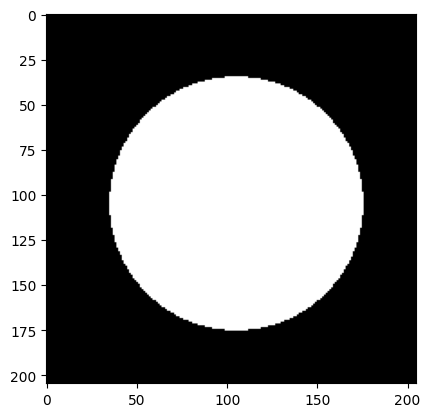

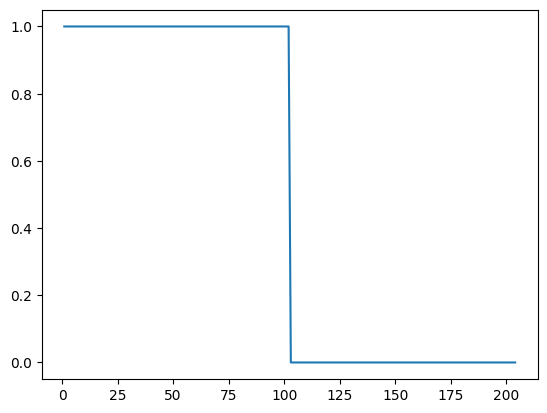

In [50]:
img = cv2.imread(f'{workpath}\\mini_test_2.jpg',0)
img = invert(img)

img_mask = cv2.fastNlMeansDenoising(img , h=50 , templateWindowSize=7 , searchWindowSize=21)
img_mask = cv2.GaussianBlur (img_mask ,ksize=(11,11),sigmaX=5)
img_mask = cv2.threshold(img_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.figure()
plt.imshow(img_mask,cmap='gray')

Les_grid = [i for i in range(1,len(img))]
Les_particules = [ count_binary_shape_grid_j(img_mask,grid) for grid in Les_grid]



plt.figure()
plt.plot(Les_grid ,Les_particules)
plt.show()